# Projektarbeit NLP (Document Classifier)

Lösung zur Projektarbeit im Fach Natural Language Processing (NLP). 

**Gruppe: Lukas Kölbl, Fabian Schmidt**

<a id="0"></a>
 # Gliederung
1. [Datensammlung](#1)     
    1. [Manuelle Datenexploration](#2)
    2. [Automatisierte Datenerfassung](#3)
2. [Datenaufbereitung](#4) 
1. [Datenverarbeitung, Visualisierung und Auswertung/Beurteilung](#5) 
    1. [Transformer-Modelle](#6)     
    2. [Extraktion der Sentence & Word Embeddings](#7)
    3. [Clustering, Visualisierung und Bewertung der "Cluster](#8)
    4. [Topic Klassifikation & Zuordnung](#9)


## Hinweis zum Ausführen des Projektes auf den Rechnern im DC107
Wir haben die Ausführung der Projektarbeit dort getestet und sie funktioniert auch. Wichtig dafür ist jedoch die richtige Ausführung der Schritte, die nachfolgend aufgelistet sind. Das Projekt wurde mit Python 3.11.7150 erstellt.

- Das Projekt wurde auf Chrome getestet (im DC0107), auf Firefox lief die Projektarbeit leider nicht wie erwartet. Zu Hause wurde das Projekt ebenfalls in Google Chrome und PyCharm entwickelt
- Für den GPU Support muss [CUDA](https://developer.nvidia.com/cuda-downloads) installiert sein (wir sind uns nicht sicher, ob dies auf jedem Rechner der Fall ist)
- Danach muss ein environment initialisiert werden (CUDA muss vorher bereits installiert sein, das ist wichtig, sonst funktioniert der GPU Support nicht)
- Environment mit source env_name/bin/activate aktivieren, dann mit **pip install -r requirements.txt** die requirements installieren
- Seperat [pytorch](https://pytorch.org/get-started/locally/) installieren
- Danach kann ganz normal der jupyter kernel installiert und das Projekt ausgeführt werden

Die seperate Installation von Pytorch ist erforderlich, da in unserem Fall bei pip freeze > requirements.txt die pytorch Installationskommandos falsch übernommen wurde. Die Installation des jeweiligen requirements.txt files führte dann zu Versionskonflikten und schlug fehl, weswegen wir pytorch aus dem requirements file gelöscht haben. Alle nötigen Unterordner (data_and_preprocessing und embeddings), in denen die Embeddings und gesäuberten Dokumente abgelegt werden, sind bereits in der Zip-Datei mit enthalten.<br>

Der Code der einzelnen Aufgabenbereiche wurde in seperate Python-Dateien ausgelagert, da so eine bessere Übersichtlichkeit gewährleistet werden kann. Diese befinden sich im selben Ordner wie dieses Jupyter-Notebook.

## Datensammlung (Crawler für die OTH Website)<a class="anchor" id="1"></a>


### Mögliche Probleme / Challenges
- Text liegt teils in zwei Sprachen (English und Deutsch) vor.
- Abkürzungen im Text selbst (POC, ECTS, TOEIC usw.)
- Sonderzeichen (+, (, ), *, usw.)
- Zahlen
- Hyperlinks
- Aufzählungen und Überschriften (Sätze ohne . am Ende)
- Buttons (Bspw. Zurück Button)
- Side-menus (Auswahlmenüs, welche nur Überschriften verlinken)
- Unicode Zeichen (vor allem in PDFs)

In [9]:
import crawler, re
from lingua import Language

start_url = "https://www.oth-aw.de/en/"
url_pattern = re.compile(r'(www\.oth-aw\.de\/en\/|www\.oth-aw\.de\/files)')
rem_objects = ["button", "subnav-link", "btn btn-light", "carousel-content"]
exclude_obj_w_class = [('div', "alert alert-error")]
languages = [Language.ENGLISH, Language.GERMAN]

crawler = crawler.Crawler(
              start_url,
              url_pattern, 
              rem_objects, 
              exclude_obj_w_class,
              languages,
              link_thresh=1000, 
              main_tag='page-content',
          )
crawler.crawl_urls()

### Manuelle Datenexploration <a class="anchor" id="2"></a>
- Wie sehen die inhaltlichen Textstrukturen aus?
    - Inhaltlich hauptsächlich allgemeine Informationen über den Studiengang
    - Aber auch Beschreibung, weswegen dieser wichtig ist
    - Teilweise einzelne Wörter ohne textuellen Zusammenhang (Hyperlinks zu Kontakt, Adresse o.ä. unten auf der Website)
- Wie und in welcher Form werden alle Textinformationen dargestellt?
    - Text wird teils in Englisch / Deutsch oder anderen Sprachen angezeigt
    - Strukturell findet sich oft Fließtext, aber auch Aufzählungen / Stichpunkte
    - Überschriften / Unterüberschriften (Im Sinne also oft einzelne Wörter) sind ebenfalls vorhanden
    - Menüpunkte mit Buttons
    - Verlinkung von Informationen oder anderen Websiten
- Reduntante Strukturen / Inhalte?
    - Teils ist dieselbe Website nur in anderen Sprachen (Tschechisch, Russisch usw.) verlinkt
    - Ansonsten ähnelt sich der Aufbau auch in diesem Fall wieder (Überschriften gefolgt von Fließtext und Aufzählungen zwischendrin)
    - Fast alle Seiten der OTH besitzen denselben Kopf und Fußzeileninhalt (Verlinkungen von Kontakt, FAQs usw.). Diese sollten in der Textinformation selbst auch entfernt werden, da kein zusätzlicher Informationsgewinn entsteht

### Automatisierte Datenerfassung <a class="anchor" id="3"></a>

#### Zusätzliche Interpretationen / Erkenntnisse 

##### Erkenntnisse beim crawlen von Websites
- Beim crawlen einer Website kam es öfter vor, dass Sätze ohne separierendes Leerzeichen zusammenhingen
- Dieses Problem tritt auf, wenn die get_text() Methode one separator aufgerufen wird, verschachtelte Textinhalte aus verschiedenen HTML Containern werden dabei ohne separator
- Aus diesem Grund wird als separator " " verwendet, dies hat allerdings noch zusätzliche Auswirkungen auf emails, mehr hierzu noch im Kapitel [Datenaufbereitung](#4) 
- Zudem wird der strip Parameter verwendet, um direkt überflüssige linebreaks und whitespaces zu entfernen.
- Teils sind verlinkte Seiten nicht erreichbar, dabei wird die jeweilige Website übersprungen.
- Zudem sind externe Seiten verlinkt, also Seiten die mit der OTH direkt nichts zu tun haben (beispielsweise Deepl und andere). An dieser Stelle ist es wichtig, bei der initialisierung des Crawlers ein geeignetes url_pattern zu definieren, welches nur die gewünschten urls matcht (In diesem Fall: r'(www\.oth-aw\.de\/en\/|www\.oth-aw\.de\/files)'. So kann sichergestellt werden, dass nur themenrelevante Inhalte gespeichert werden.
    - Eine Sprachfilterung kann durch geschickte Wahl des regexps (en im link) bereits vorab grob geschehen
    - Dies verhindert jedoch nicht anderssprachige Inhalte! (Mehr dazu im Kapitel [Datenaufbereitung](#4))
- Oft werden auch Inhalte verlinkt, die für die vorliegende Aufgabe generell nicht brauchbar sind (beispielsweise Bilder), auch diese Einträge werden übersprungen
- Header und footer, sowie Buttons und spezifische Klassen werden bereits beim crawling Vorgang entfernt, mehr hierzu im nachfolgenden Kapitel zur [Datenaufbereitung](#4) 
##### Erkenntnisse beim crawlen von PDFs
- Parsing von PDFs gestaltet sich als sehr schwierig. Bei normalen Websites ist es leicht, bestimmte Elemente nach ihrem tag, Objekttypen oder Klassennamen zu filtern
- Das ist bei PDFs eher schwierig, Text und Elemente sind im Dokument kreuz und quer verteilt. Es sind zudem unerwünschte Elemente wie Formeln, QR-Codes usw. enthalten
    - In Folge dessen erhält man nach dem crawling Vorgang eher unschöne Ergebnisse. An dieser Stelle wurden auch verschieden Bibliotheken getestet (PyPDF4, pdfplumber, PyMuPDF)
    - Am Ende stellte sich PyMuPDF als am zuverlässigsten heraus
    - Aber auch diese Bibliothek kann - zumindest nicht leicht und schnell - diese unerwünschten Inhalte nicht filtern
    - Mehr zum filtern dieser Inhalte folgt ebenfalls im Kapitel zur [Datenaufbereitung](#4) 
##### Zusätzliche Erkenntnisse
- Wir fanden es sinnvoll, die gecrawlten PDF Dateien zusätzlich in einem Ordner abzuspeichern. So kann - sollte bei einem crawling Durchlauf ein Fehler beim PDF parsing passieren - dieser besser nachvollzogen werden, da die betroffene PDF hierbei zur Verfügung steht und die jeweilige Stelle direkt im Dokument gesucht werden kann
- Der Baum mit den jew. links soll ebenfalls dauerhaft als Datei verfügbar sein um gegebenenfalls auf bestimmte Seiten zurückgreifen zu können und den crawling Vorgang besser nachzuvollziehen
- Die einzelnen Loginformationen für jeden crawling Vorgang werden zusätzlich in einem logfile abgespeichert, so kann bei potenziell fehlerhaften Daten der zugehörige Fehler leicht gefunden werden

## Datenaufbereitung <a class="anchor" id="4"></a>
Essenziell für die Aufbereitung der Daten ist eine Übersicht über relevante / irrelevante Textbausteine. Allgemein können so zumindest die offensichtlichen, problematischen Stellen bereits im Vornherein ausfindig gemacht und eliminiert werden. Für eine feinere Säuberung der Daten muss noch eine manuelle Überprüfung des Datensatzes nach dem ersten Preprocessing Durchgang durch evtl. Stichproben erfolgen, um weniger offensichtliche, irrelevante Textbausteine zu idendifizieren.
### Irrelevante Textbausteine
- Email-Adressen, Telefonnummern, Faxnummern
- Kopf/Fußzeilen und Menüs (diese sind i.d.R. gleich und verweisen lediglich auf andere Seiten)
- Sonderzeichen, Zeilenumbrüche, Unicode, Zeit/Datumsangaben
- Stopwords 
### Relevante Textbausteine
- Fließtext innerhalb der Seite
- Überschriften / Unterschriften

In [ ]:
import preprocessor

#Regular Expressions
dates = re.compile(r'(3[01]|[12][0-9]|0?[1-9])(\.|-|\/)(1[0-2]|0?[1-9])\2([0-9]{2})?[0-9]{2}')
email_split = re.compile(r'\b[A-Za-zäöüÄÖÜß0-9._%+-]+ @ [A-Za-z0-9.-]+ \. [A-Z|a-z]{2,}\b')
email = re.compile(r'\b[A-Za-zäöüÄÖÜß0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')
tabs_newlines = re.compile(r'(\\[nt]\s*)')
links = re.compile(r'(https?:\/\/)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&\/=]*)')
hashtags = re.compile(r'([#][\w_-]+)')
whitespace = re.compile(r'(\s{3,})')
en_time = re.compile(r'([0-2][0-9]:[0-5][0-9]([pm]|[am])*)|([0-2]*[0-9]*:*[0-5][0-9]([pm]|[am])+)|([0-9][0-9]*([pm]|[am])+)')
de_time = re.compile(r'([0-2][0-4]([uhr]{3,3}|[\suhr]{3,4}))|([0-2][0-4]\:[0-5][0-9]([uhr]{3,3}|[uhr\\s]{3,4}|$))')
sent_patt = re.compile('(?<!\.|\!|\?|\:|\;|\s)\w[.,:;!?]\s+')
phone_fax = re.compile(r'(((fax )|(mobil )|(tel\.: )|(phone ))?\+49\s[0-9\s\-]+[0-9])')
mult_plus = re.compile(r'\+\s+')
mult_minus = re.compile(r'\−\s+')

#Map regs to their corresponding replacement word
reg_mappings = [
    (' DATE ', dates), (' EMAIL ', email), 
    (' EMAIL ', email_split), (' LINK ', links), 
    (' HASHTAG ', hashtags), (' ', whitespace), 
    (' ', tabs_newlines), (' TIME ', de_time), 
    (' TIME ', en_time), (' PHONE ', phone_fax),
    ('', mult_plus), ('', mult_minus),
]

data_folder = "data_and_preprocessing/"
#Regex clean the crawled data
prepro = preprocessor.Preprocessor(reg_mappings, sent_patt)
prepro.regex_preprocessing(f"{data_folder}crawler_result.json")

#Remove non-english words from regex cleaned data
prepro.rem_non_english_words(f"{data_folder}crawler_result_regex_cleaned.json")

#lemmatize and tokenize preprocessed data
prepro.lemmatize(f"{data_folder}crawler_result_lang_cleaned.json")

### Preprocessing durch reguläre Ausdrücke
- Zum Entfernen von stukturbehafteten Daten (z.B Datum, Emails, Links, Zeiten) werden reguläre Ausdrücke verwendet. Auf diese werden auch mehrere, aufeinander folgende Zeilenumbrüche und Einrückungen bereinigt, die beim crawling Vorgang noch nicht entfernt wurden
- Für die Emails folgt ein Sonderfall: Durch den seperator Parameter in der Funktion get_text beim crawlen einer url werden manche emails folgendermaßen im Text dargestellt: example.mail @ oth-aw . de
- Dies hängt - wie bereits erwähnt - vermutlich mit der Struktur der OTH Websites zusammen, bei der Email Adressen verschachtelt in verschiedenen HTML-Containern abgespeichert werden
    - An dieser Stelle wurde - zusätzlich zum normalen email regex - ein regex email_split eingeführt, der diese Struktur berücksichtigt
- Die verschiedenen Seiten der OTH Amberg enthalten vor allem viele Kontaktdaten (Telefonnummern, Fax, Email usw.)
- Diese Aufgabe lässt sich am besten mit regulären Ausrücken lösen, da sich so die oben erwähnten Strukturen leicht verallgemeinern und filtern lassen
### Manuelle Preprocessing Schritte beim crawlen
- Header und footer werden - wie bereits erwähnt - schon beim crawling Vorgang aussortiert
- Diese Bereiche einer Seite ähneln sich über viele der Unterseiten hinweg, sind jedoch manchmal marginal unterschiedlich (manchmal sind mehr Seiten im header verlinkt, manchmal weniger, manche Punkte sind teils anders benannt usw.)
- Dieser Aufbau macht es schwierig bis unmöglich, zuverlässig alle header und footer manuell durch reguläre Ausdrücke zu entfernen
- Da jede der Unterseiten der OTH Website den relevanten Haupttext der jeweiligen Website in einem div mit derselben id (page_content) speichert, kann dieser Text bereits beim crawling Vorgang mit dem bs4 package gefiltert werden
- So wird nur der Text aus diesem div übernommen, header und footer Text werden direkt beim crawlen aussortiert
- Da header und footer keine textuell wichtigen Informationen über den Seitenhinhalt enthalten müssen sie auch zwingend entfernt werden, da sonst die Themenzuweisung davon beeinflusst wird
- Dies gilt ebenso für Websitelemente wie buttons oder Seitenmenüs, welche auf manchen Seiten vorhanden sind
- Auch hier ist der textuelle Inhalt oft anders und kann schwer generalisiert werden
- Beim crawlen direkt können diese Inhalte mit folgenden Klassen bzw. Objektypen entfernt werden:
    - "subnav-link" für side-menus
    - "alert alert-error" für Error text der ebenfalls nach dem crawlen im Text enthalten ist
    - "btn btn-light" für extra angelegte Zurück Buttons
    - "button" für Button Objekte (obiger Zurück Button ist kein Button Objekt)
    - "carousel-content" für Untermenüs / Dropdowns
- Hierbei sei erwähnt, dass auch diese Filterung am Ende nicht perfekt durchgeführt werden kann, es wird immer Elemente mit einer anderen Klasse geben
- Die eben genannten Punkte lieferten die für uns am besten ersichtliche Qualität hinsichtlich der Filterung solcher Elemente 
### Satz und Wortkonvertierung
Um ein Dokument zu kategorisieren, muss dieses zunächst in seine einzelnen Sätze und danach in die einzelnen Wörter aufgeteilt werden. 
- Zur Tokenization der Sätze/Wörter wird die nltk Bibliothek verwendet.
    - Prinzipiell können für die Sentence Tokenization auch reguläre Ausdrücke verwendet werden, allerdings müssen dafür manuell alle Sonderfälle (Abkürzungen mit Punkt, Doppelpunkte, Überschriften usw.) abgedeckt werden, dies ist jedoch umständlich
    - Der hier verwendete Tokenizer (PunktSentenceTokenizer) verwendet einen unsupervised Algorithmus um ein Modell für die Satzidendifikation aufzubauen. Diese Vorgehensweise eignet sich besonders für europäische Sprachen <sup>[1](#punkt_sent_tokenizer)</sup>
- Zudem werden stopwords mit der nltk Bibliothek entfernt, die eine vorgefertigte Sammlung dieser Wörter für verschiedene Sprachen (hier: Englisch) bereitstellt
    - Besonders für die vorliegende Aufgabe der Themenidendifizierung können diese problematisch werden, da sie dokumentenübergreifend einen Großteil des Textes der jeweiligen Dokumente ausmachen und somit die Themenzuweisung stark beeinflussen. Sie bieten jedoch keinerlei  Informationsgehalt und müssen deswegen zwingend entfernt werden
- Für die Wortkonvertierung wird Lemmatization mit dem WordNetLemmatizer durchgeführt
    - Zunächst müssen dazu die einzelnen Wörter aus den jeweiligen Dokumenten idendifiziert werden, dies wird mittels der word_tokenize Methode aus der nltk library realisiert
    - Diese berücksichtigt bereits standardmäßig einige Sonderfälle in der Worterkennung (Abkürungsformen im Englischen, Behandlung von Punkten usw.)     <sup>[2](#word_tokenizer)</sup>
    - Prinzipiell besteht auch für die Worterkennung die Möglichkeit, reguläre Ausdrücke zu benutzen. Diese Methode wäre zwar etwas flexibler, jedoch müssen - wie schon bei der Satzerkennung - alle Sonderfälle berücksichtigt werden, was in Anbetracht der Datenmenge in der vorgegebenen Zeit nicht möglich ist
- Schlussendlich müssen Wortvariationen eliminiert werden
- So können die im Dokument verwendeten Wörter auf ihre Grundform gebracht werden um für jedes Wort nur eine Ausführung zu haben
- Für das vorliegende Projekt wurde der WordNetLemmatizer verwendet
- Dieser erhält - im Gegensatz zu Alternativen wie dem PorterStemmer - beim Vorgang des stemmings die ursprüngliche Wortbedeutung bei
- Dies ist für die Themenzuweisung essenziell, da so der Kontext und die Wort bzw. Satzbedeutung erhalten bleibt und nicht abgeändert wird
### Sprache
- Ein weiterer, kritischer Punkt beim Preprocessing stellt die Sprache des jeweiligen Dokuments dar
- Oft haben Websites sowohl englische als auch deutsche Sätze / Wörter
- Der Großteil davon wird bereits beim crawling durch die Sprachenüberprüfung aussortiert
- Jedoch ist dies nicht ausreichend, denn ein Text mit bspw. 1000 englischen und 5 deutschen Sätzen wird mit großer Wahrscheinlichkeit als Englisch klassifiziert
- An dieser Stelle wird das Dokument also beibehalten
- Im hodchdimensionalen feature-space werden gleichbedeutende englische und deutsche Wörter jedoch mit großer Wahrscheinlichkeit weit auseinander liegen
- Aus diesem Grund werden die verbleibenden deutschen bzw. anderssprachigen Wörter in den Dokumenten manuell entfernt
- Jedes Dokument wird in Sätze und einzelne Wörter aufgeteilt, Wörter die nicht im englischen Vokabular vorkommen (wir haben auf das british-english unix vocabular unter usr/share/dict/words zurückgegriffen) werden entfernt
- Dabei werden auch im selben Zug anderssprachige Wörter gefiltert
### Alternative Verarbeitungstechniken
- Es gibt noch mehr Möglichkeiten des Text Preprocessings
- Hierunter zählen beispielsweise POS-(Part-of-Speech) Tagging und NER (Named Entity Recognition)
    - Wir haben uns gegen NER entschieden, da hierbei zu viel Context verloren geht
    - Für POS-tagging konnten wir abseits von generellen Analysen des Textes keine Verwendung für dieses Projekt finden 

## Datenverarbeitung, Visualisierung und Auswertung/Beurteilung <a class="anchor" id="5"></a>
### Transformer-Modelle <a class="anchor" id="6"></a>
- Für das Laden der Transformer Modelle wird die offiziell empfohlende Vorgehensweise in den jeweiligen Dokumentationen verwendet
    - T5: https://huggingface.co/docs/transformers/model_doc/t5
    - Gpt-Neo: https://huggingface.co/docs/transformers/model_doc/gpt_neo
- Im nächsten Abschnitt wird die feature extraction und somit die Verwendung der Modelle im Kontext dieser Arbeit genauer beschrieben 

### Extraktion der Sentence & Word Embeddings <a class="anchor" id="7"></a>
- Für die Extraktion der Sentence und Word Embeddings wurde die transformers Bibliothek verwendet
- die Sentence Embeddings können über die last_hidden_states des jeweiligen Modells extrahiert werden
- der hochdimensionale Feature-Vektor (Sentence Embedding) wird mittels averaging auf einen 1x1x2048 Vektor komprimiert
- Die Word Embeddings können vor dem averaging den jeweiligen Sentence Embeddings direkt entnommen werden, ein zusätzlicher Extraktionsschritt ist nicht vonnöten
- Für jedes Dokument werden die Sentence Embeddings in einer Liste abgespeichert
- Die Word Embeddings werden ebenfalls für jedes Dokument in einer Liste abgespeichert
    - Wir haben die Word Embeddings zuerst noch nach Sätzen geordnet, da dies jedoch im Nachgang bei den TSNe Plots Probleme verursachte entschieden wir uns für obige Variante 

In [ ]:
import os

#Enable detailed logging in case the program crashes due to e.g. a hardware or memory problem on the GPU
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
import embeddings, json, torch
from transformers import T5Tokenizer, T5Model, AutoTokenizer, GPTNeoModel

#Load documents
f = open("data_and_preprocessing/crawler_result_lemmatized.json", "r")
data = json.load(f)
f.close()

#Get gpu as device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Get the T5 model
torch.cuda.empty_cache() #Empty cache in case an old model is still saved on the gpu
t5_model_name = "t5-base"
t5_model = T5Model.from_pretrained(t5_model_name).encoder.to(device)
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_name, model_max_length=512, truncation=True, padding=True)

#Get the gpt-neo-1.3B model
torch.cuda.empty_cache() #Empty cache in case an old model is still saved on the gpu
gpt_neo_model_name = "EleutherAI/gpt-neo-1.3B"
gpt_neo_model = GPTNeoModel.from_pretrained(gpt_neo_model_name).to(device)
gpt_neo_tokenizer = AutoTokenizer.from_pretrained(gpt_neo_model_name)

#Generate and save the corresponding embeddings
embeddings.get_embeddings(data, t5_model, t5_tokenizer, device)
embeddings.get_embeddings(data, gpt_neo_model, gpt_neo_tokenizer, device) 

### Clustering, Visualisierung und Bewertung der "Cluster" <a class="anchor" id="8"></a>

#### Erster Clustering-Lauf
Für den ersten Clustering-Lauf wird das Sentence Embedding des Dokuments [https://www.oth-aw.de/en/](https://www.oth-aw.de/en/), das durch den T5-Base Transformer erstellt wurde, verwendet.

In [1]:
import ujson
import topic_classification

embeddings_source={
    "embeddings/t5_embeddings/sentence_embeddings/sents_0.json":"https://www.oth-aw.de/en/",    
}
embeddings_1docs={}

# load document
for key, value in embeddings_source.items():
    with open(key, "rb") as f:
        embeds = ujson.load(f)
        embeddings_1docs[value] = embeds[value]
        f.close()

In [2]:
import numpy as np
silhouette_scores_1doc = {}

# calculate silhouette scores
for key, value in embeddings_1docs.items():    
    silhouette_scores_1doc[key] = topic_classification.calc_silhouette_scores(np.array(list(embeddings_1docs[key])), len(embeddings_1docs[key]) - 1)

In [3]:
cluster_to_find = silhouette_scores_1doc['https://www.oth-aw.de/en/'].index(max(silhouette_scores_1doc['https://www.oth-aw.de/en/'])) + 2

# find clusters
cluster_1docs = {}
for key in silhouette_scores_1doc.keys():
    cluster_1docs[key] = topic_classification.cluster_kmeans_sentence(embeddings_1docs[key], cluster_to_find)

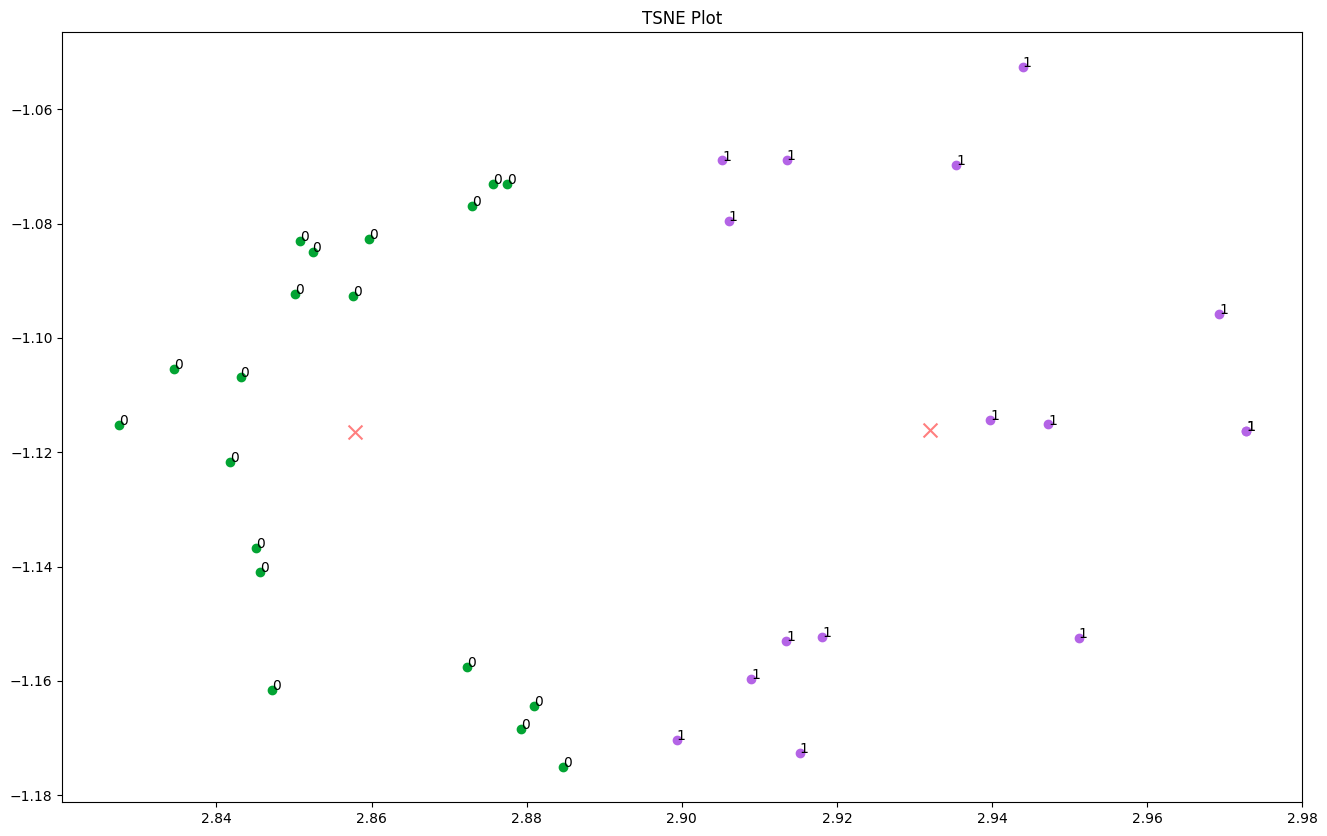

Inertia: 0.06261341273784637
zu findende Cluster: 2
Silhouette Score: [0.18761851496602602, 0.07259796432756448, 0.07819859960346402, 0.06531675858287948, 0.10532324090013195, 0.07775101160514201, 0.10293149463628892, 0.09540554914428592, 0.09639188249269756, 0.10954920738418426, 0.10254046424580943, 0.08511719852748306, 0.11330108661790521, 0.10528394150662324, 0.09986353469514209, 0.10002262093193912, 0.09401509452314254, 0.1041717017948023, 0.09994129774316558, 0.09963563549360828, 0.09380926170817303, 0.10215317965406258, 0.10012323415458023, 0.09968941976707618, 0.09776412867094882, 0.09602917124955358, 0.0936356064052071, 0.08613140244661636, 0.0775284935253159, 0.07414918319022837, 0.06969143847455571, 0.0648020279881718, 0.05714285714285714]


In [4]:
# visualize
topic_classification.tsne_plot_document(cluster_1docs, cluster_to_find)
print(f"zu findende Cluster: {cluster_to_find}")
print(f"Silhouette Score: {silhouette_scores_1doc['https://www.oth-aw.de/en/']}")

### Erkenntnisse aus dem ersten Clustering-Lauf mit t5-Base-Sentence-Embeddings:
- Der Silhouetten Score beschreibt, "wie gut" Cluster voneinander getrennt sind. Der Wert reicht von -1 bis 1. 
    - Ein Wert von 1 indiziert, dass samples weit entfernt von benachbarten Clustern liegen.
    - Ein Wert von 0 indiziert, dass samples sehr nah bei benachbarten Clustern liegen.
    - Ein Wert von -1 indiziert, dass samples womöglich falsch zu geordnet wurden.

  Ein positiver Wert ist demnach wünschenswert. Je höher desto besser.
  Für das Dokument [https://www.oth-aw.de/en/](https://www.oth-aw.de/en/) beträgt der Silhouetten Score: 0.20326854450725795 für 2 Cluster.
  Dementsprechend wurde für die obige das Dokument in 2 Cluster eingeteilt.
   
Als Kenngrößen für das Clustering wird Intertia angegeben. Inertia beschreibt die Summer der quadratischen Abstände innerhalb der Cluster.
<b>Ziel: </b> Inertia minimieren. Eine niedrigere Inertia deutet auf kompaktere Cluster hin.

#### Clustering mit n zufälligen Dokumenten
Im Folgenden wird ein Clustering-Lauf mit n zufälligen Dokumenten dargestellt.<br><br>
<b>Zu Beachten: </b>Hierbei werden jedoch zu kleine Dokumente ignoriert, da dort kein sinnvolles Clustering durchgeführt werden kann (als zu klein gelten Dokumente mit nur einem Satz). Ebenfalls werden zu große Dokumente gefiltert, da dort die Berechnung des silhouetten scores für Word Embeddings sehr viel Zeit in Anspruch nimmt (als zu groß gelten Dokumente mit über 200 Wörtern und über 4 Sätzen, beide Werte sind über die get_viable_documents Methode einstellbar). 

In [1]:
import ujson
import os

def load_n_embedding_files(path, n):
    """
    Load embeddings from JSON files in the specified directory.

    Parameters:
    path (str): The path to the directory containing JSON files with embeddings.
    
    embedding_type (str): Type of embedding to load
    
    list (list of strings): List of files to load

    Returns:
    dict: A dictionary containing merged embeddings from all JSON files.
    """
    
    all_data = []
    
    # Check if directory includes enough documents
    if len(os.listdir(path)) <= n:
        print(f"{path} only includes {len(os.listdir(path))} files. Setting n to {len(os.listdir(path))}")
        n = len(os.listdir(path))
    
    loaded_files = 0
    # Iterate through all files in the directory
    for filename in os.listdir(path):        
        if filename.endswith('.json'):
            file_path = os.path.join(path, filename)  
            # break if n files are loaded
            if loaded_files == n:
                break
            try:                
                # Load the content of each JSON file
                with open(file_path, 'rb') as f:
                    embeds = ujson.load(f)
                    all_data.append(embeds)
                    loaded_files += 1
            except: 
                continue

    # merge collected data into one dictionary
    merged_data = {}
    for data in all_data:
        merged_data.update(data)
    
    return merged_data    
        
        
all_embeddings = {}


# Load the documents
documents_to_load = 40
all_embeddings["T5 Base Sentence Embeddings"] = load_n_embedding_files('embeddings/t5_embeddings/sentence_embeddings/' , documents_to_load )
all_embeddings["T5 Base Word Embeddings"] = load_n_embedding_files('embeddings/t5_embeddings/word_embeddings/' , documents_to_load)
all_embeddings["GPT Neo Sentence Embeddings"] = load_n_embedding_files('embeddings/gpt_neo_embeddings/sentence_embeddings/' , documents_to_load)
all_embeddings["GPT Neo Word Embeddings"] = load_n_embedding_files('embeddings/gpt_neo_embeddings/word_embeddings/' , documents_to_load)

In [2]:
import topic_classification
import numpy as np
import random

def get_viable_documents(word_count =200, sentence_count = 4):
    """
    This function filters a set of documents based on specified word and sentence count criteria.

    Parameters:
    word_count: Maximum allowable word count for a document. Defaults to 200.
    sentence_count: Minimum allowable sentence count for a document. Defaults to 4.

    Returns:
    A set of document keys that meet the specified criteria.
    """

    viable_documents = set()
    
    # parse all keys
    for key, value in all_embeddings["T5 Base Word Embeddings"].items():
        # filter documents that are too small/large
        if len(list(value)) <= word_count and (sentence_count >= len(list(all_embeddings["T5 Base Sentence Embeddings"][key])) > 2):
            viable_documents.add(key)
    return viable_documents

def get_silhouette_scores(documents, type):
    """
    Calculate silhouette scores for each document in the given collection.

    Parameters:
    documents (dict): A dictionary where keys represent document identifiers and values contain the data for each document. Format: {document_id: {element_id: data}}
    
    type (str): The type of data in the documents ('sentence' or another specified type).

    Returns:
    silhouette_scores (dict): A dictionary where keys are document identifiers and values
                               are silhouette scores calculated for each document.
    """
    
    silhouette_scores= {}
    
    for link in documents:
        print(f"Calculating silhouette scores for: {link}")
        if type == "sentence":
            silhouette_scores[link] = topic_classification.calc_silhouette_scores(np.array(list(documents[link])), len(documents[link]) - 1)
        elif type == "word":
            silhouette_scores[link] = topic_classification.calc_silhouette_scores(np.array(documents[link]), len(documents[link]) - 1)
        else:
            print("Unkown type. Use 'sentence' or 'word'")
            return
    
    return silhouette_scores

document_sample = random.sample(list(get_viable_documents()), 50)
document_silhouette_scores = {}
document_silhouette_scores["T5 Base Word Embeddings"] = get_silhouette_scores({key: all_embeddings["T5 Base Word Embeddings"][key] for key in document_sample if key in all_embeddings["T5 Base Word Embeddings"]}, "word")
document_silhouette_scores["T5 Base Sentence Embeddings"] = get_silhouette_scores({key: all_embeddings["T5 Base Sentence Embeddings"][key] for key in document_sample if key in all_embeddings["T5 Base Sentence Embeddings"]}, "sentence")
document_silhouette_scores["GPT Neo Sentence Embeddings"] = get_silhouette_scores({key: all_embeddings["GPT Neo Sentence Embeddings"][key] for key in document_sample if key in all_embeddings["GPT Neo Sentence Embeddings"]}, "sentence")
document_silhouette_scores["GPT Neo Word Embeddings"] = get_silhouette_scores({key: all_embeddings["GPT Neo Word Embeddings"][key] for key in document_sample if key in all_embeddings["GPT Neo Word Embeddings"]}, "word")

Calculating silhouette scores for: https://www.oth-aw.de/en/university/about-our-university/facilities/students-office/about-the-students-office/
Calculating silhouette scores for: https://www.oth-aw.de/en/studies/study-offers/study-programmes/bachelor/digital-technology-management/information-for-companies/
Calculating silhouette scores for: https://www.oth-aw.de/en/university/about-our-university/staff/?tx_femanager_pi1%5Baction%5D=show&tx_femanager_pi1%5Bcontroller%5D=User&cHash=222011463afabc510ebe003690b14b94
Calculating silhouette scores for: https://www.oth-aw.de/en/studies/study-offers/orientation-studies-prepareing/insight/
Calculating silhouette scores for: https://www.oth-aw.de/en/studies/study-offers/study-programmes/bachelor/patent-engineering/contact/
Calculating silhouette scores for: https://www.oth-aw.de/en/studies/campus-life/marketplace/flats/searching-for-accommodation-in-amberg/
Calculating silhouette scores for: https://www.oth-aw.de/en/university/about-our-univer

C:\Users\Luki\Desktop\nlp-tasks\nlp-env-win-cuda\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (97) found smaller than n_clusters (98). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\Luki\Desktop\nlp-tasks\nlp-env-win-cuda\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (97) found smaller than n_clusters (99). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Calculating silhouette scores for: https://www.oth-aw.de/en/study-programmes-and-educational-opportunities/study-programmes/master-degree-programs/it-and-automation-ia/master-program-it-and-automation/
Calculating silhouette scores for: https://www.oth-aw.de/en/inform-yourself-and-discover/departments/mechanical-engineering-environmental-technology/gallery/
Calculating silhouette scores for: https://www.oth-aw.de/en/university/about-our-university/facilities/center-for-gender-and-diversity/offers-for-female-students/
Calculating silhouette scores for: https://www.oth-aw.de/en/studies/study-offers/orientation-studies-prepareing/exam-registration/
Calculating silhouette scores for: https://www.oth-aw.de/en/university/services/service-centre-for-digital-exercises/showroom/
Calculating silhouette scores for: https://www.oth-aw.de/files/oth-aw/Studiengaenge/Master/IEE/Dokumente/Studienplan-IEE-SS2024.pdf
Calculating silhouette scores for: https://www.oth-aw.de/en/research/research-facilitie

C:\Users\Luki\Desktop\nlp-tasks\nlp-env-win-cuda\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (43) found smaller than n_clusters (44). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Calculating silhouette scores for: https://www.oth-aw.de/en/university/about-our-university/staff/altieri-mike/
Calculating silhouette scores for: https://www.oth-aw.de/en/university/about-our-university/staff/frenzel-bernhard/
Calculating silhouette scores for: https://www.oth-aw.de/en/university/about-our-university/staff/tschapka-michael/
Calculating silhouette scores for: https://www.oth-aw.de/en/university/departments/industrial-engineering-and-healthcare/photos/
Calculating silhouette scores for: https://www.oth-aw.de/en/data-privacy/chat-counselling/
Calculating silhouette scores for: https://www.oth-aw.de/en/studies/study-offers/study-programmes/master/digital-business/contact-partners/
Calculating silhouette scores for: https://www.oth-aw.de/en/international/ways-abroad/partner-universities/
Calculating silhouette scores for: https://www.oth-aw.de/en/studies/orientation/get-prepared/
Calculating silhouette scores for: https://www.oth-aw.de/files/oth-aw/Forschung/Forschungsproj

In [3]:
def calc_cluster(silhouette_scores, model, cluster_count = 2):
    """
    Calculate clusters for each document based on silhouette scores and specified clustering model.
    
    Parameters:
    silhouette_scores (dict): Silhouette scores for each document. Format: {document_id: silhouette_score_list}
    
    model (str): The type of embedding model used for clustering ('Word' or 'Sentence').
    
    cluster_count (int, optional): The number of clusters to form for K-Means clustering. Default is 2.
    
    Returns:
    cluster_ndocs (dict): Clusters assigned to each document. Format: {document_id: {'data': original_data, 'cluster': assigned_cluster}}
    """
    cluster_ndocs = {}
    for key in silhouette_scores.keys():   
        if silhouette_scores[key].__len__() == 0:
            continue
        if "Sentence" in model:
            cluster_ndocs[key] = topic_classification.cluster_kmeans_sentence(all_embeddings[model][key],  cluster_count)
        else:
            cluster_ndocs[key] = topic_classification.cluster_kmeans_word(all_embeddings[model][key], cluster_count)
    return cluster_ndocs

#find clusters within the documents
clusters = {}
clusters_to_find = 2
clusters["T5 Base Sentence Embeddings"] = calc_cluster(document_silhouette_scores["T5 Base Sentence Embeddings"], "T5 Base Sentence Embeddings", clusters_to_find)
clusters["GPT Neo Sentence Embeddings"] = calc_cluster(document_silhouette_scores["GPT Neo Sentence Embeddings"], "GPT Neo Sentence Embeddings", clusters_to_find)
clusters["T5 Base Word Embeddings"] = calc_cluster(document_silhouette_scores["T5 Base Word Embeddings"], "T5 Base Word Embeddings", clusters_to_find)
clusters["GPT Neo Word Embeddings"] = calc_cluster(document_silhouette_scores["GPT Neo Word Embeddings"], "GPT Neo Word Embeddings", clusters_to_find)

#### Im Folgenden werden die Sentence- und Word Embeddings von T5 Base und GPT Neo mit k = 4 geclustert

Inertia für T5 Base Sentence Embeddings: 121951.2578125
Inertia für GPT Neo Sentence Embeddings: 185732.390625
Inertia für T5 Base Word Embeddings: 8.329648971557617
Inertia für GPT Neo Word Embeddings: 23.32908058166504


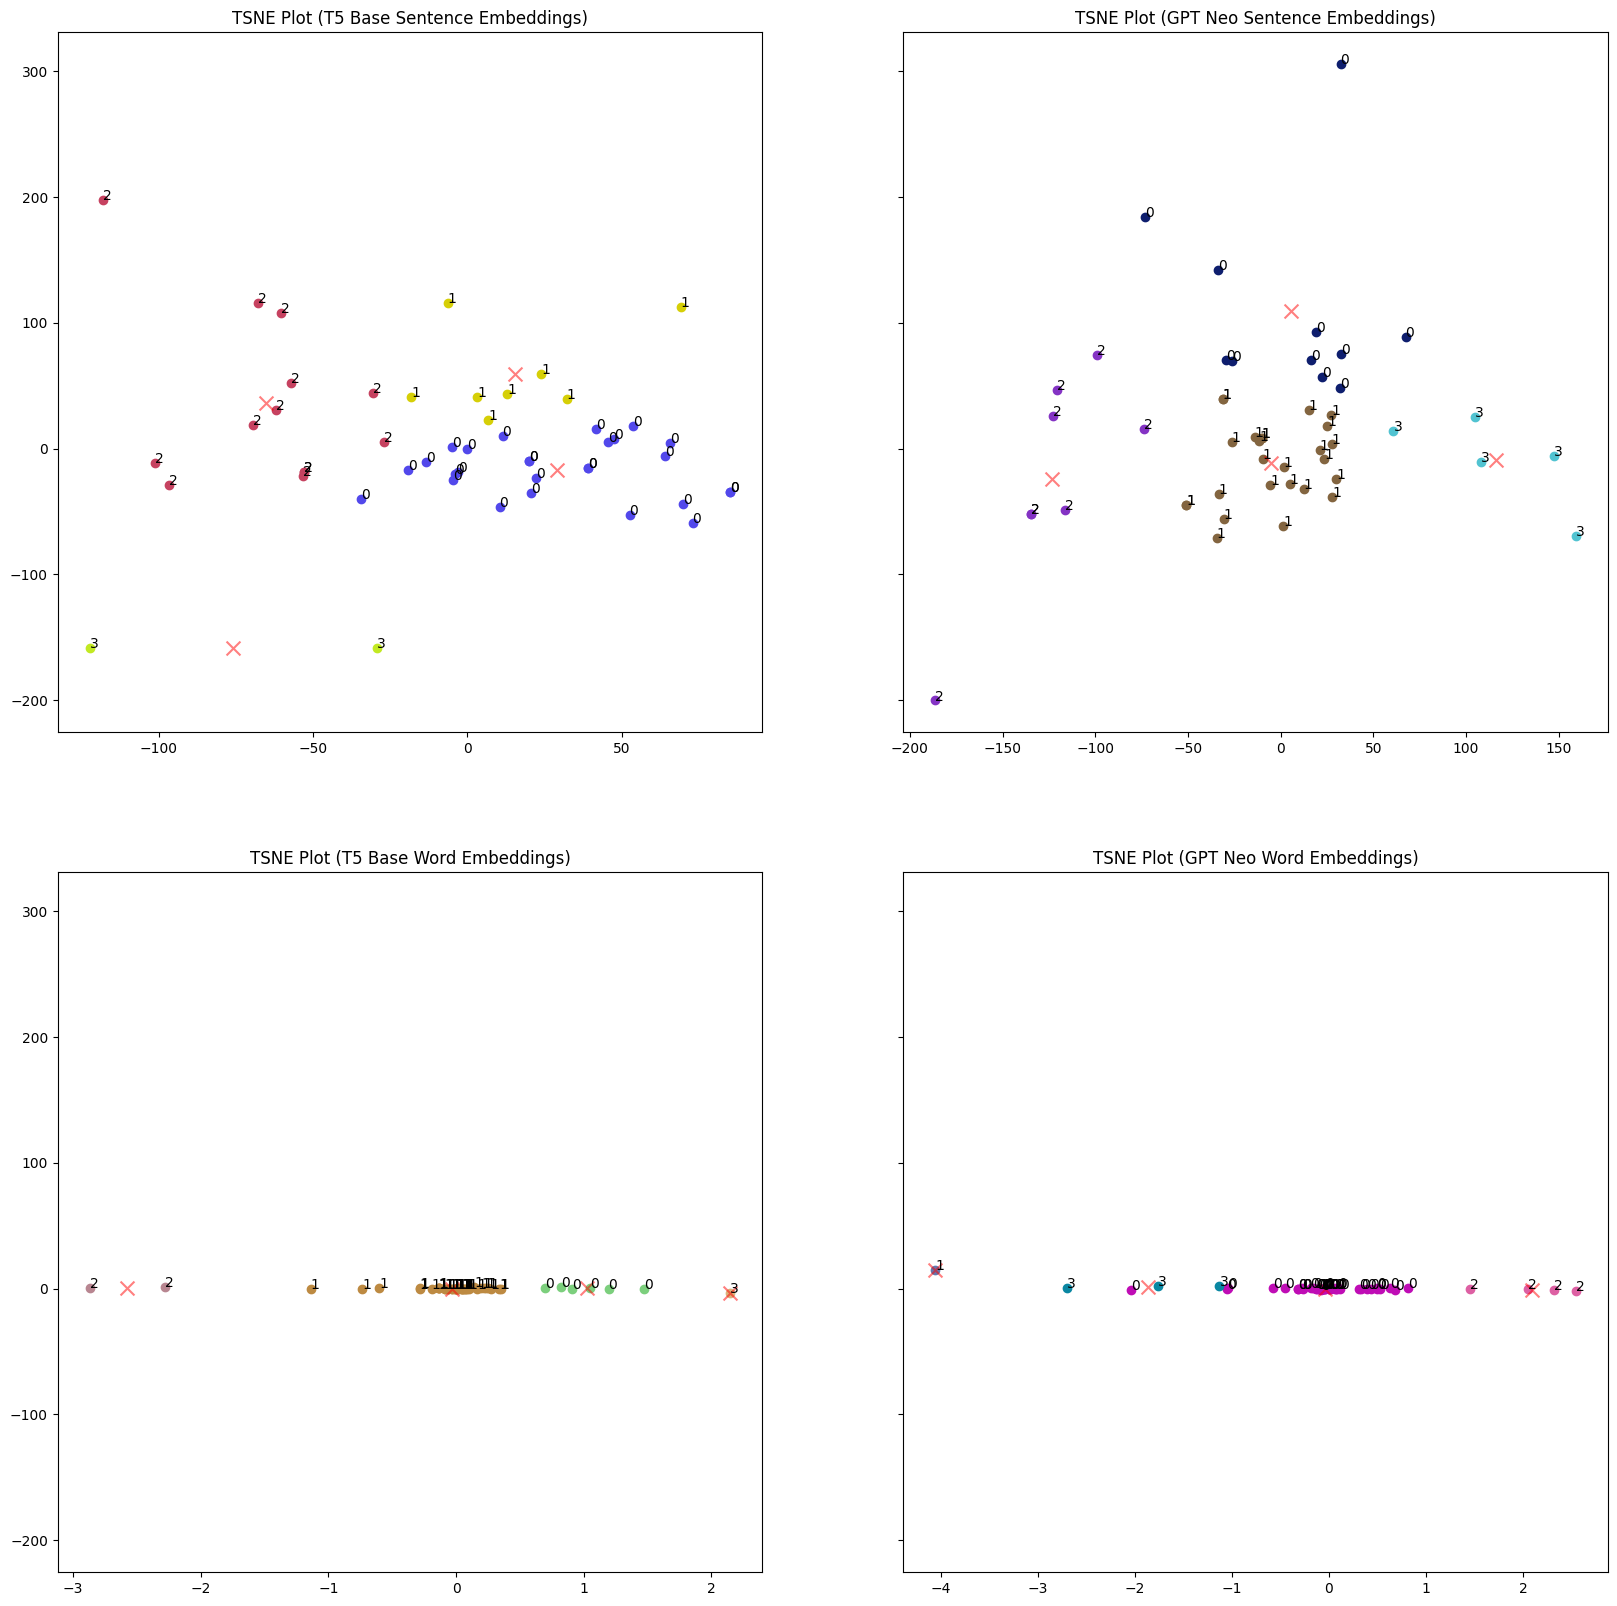

In [4]:
topic_classification.tsne_plot(clusters,4)

#### Im Folgenden wird der Silhouetten Score verwendet, um ein optimales Clusteringergebnis zu erhalten

C:\Users\Luki\Desktop\nlp-tasks\nlp-env-win-cuda\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (46) found smaller than n_clusters (47). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\Luki\Desktop\nlp-tasks\nlp-env-win-cuda\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (46) found smaller than n_clusters (48). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\Luki\Desktop\nlp-tasks\nlp-env-win-cuda\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (46) found smaller than n_clusters (49). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Inertia für T5 Base Sentence Embeddings: 1287.1790771484375


C:\Users\Luki\Desktop\nlp-tasks\nlp-env-win-cuda\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (46) found smaller than n_clusters (47). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\Luki\Desktop\nlp-tasks\nlp-env-win-cuda\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (46) found smaller than n_clusters (48). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\Luki\Desktop\nlp-tasks\nlp-env-win-cuda\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (46) found smaller than n_clusters (49). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Inertia für GPT Neo Sentence Embeddings: 26838.205078125


C:\Users\Luki\Desktop\nlp-tasks\nlp-env-win-cuda\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (46) found smaller than n_clusters (47). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\Luki\Desktop\nlp-tasks\nlp-env-win-cuda\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (46) found smaller than n_clusters (48). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\Luki\Desktop\nlp-tasks\nlp-env-win-cuda\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (46) found smaller than n_clusters (49). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Inertia für T5 Base Word Embeddings: 29.44329261779785


C:\Users\Luki\Desktop\nlp-tasks\nlp-env-win-cuda\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (46) found smaller than n_clusters (47). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\Luki\Desktop\nlp-tasks\nlp-env-win-cuda\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (46) found smaller than n_clusters (48). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\Luki\Desktop\nlp-tasks\nlp-env-win-cuda\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (46) found smaller than n_clusters (49). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Inertia für GPT Neo Word Embeddings: 62.05806350708008


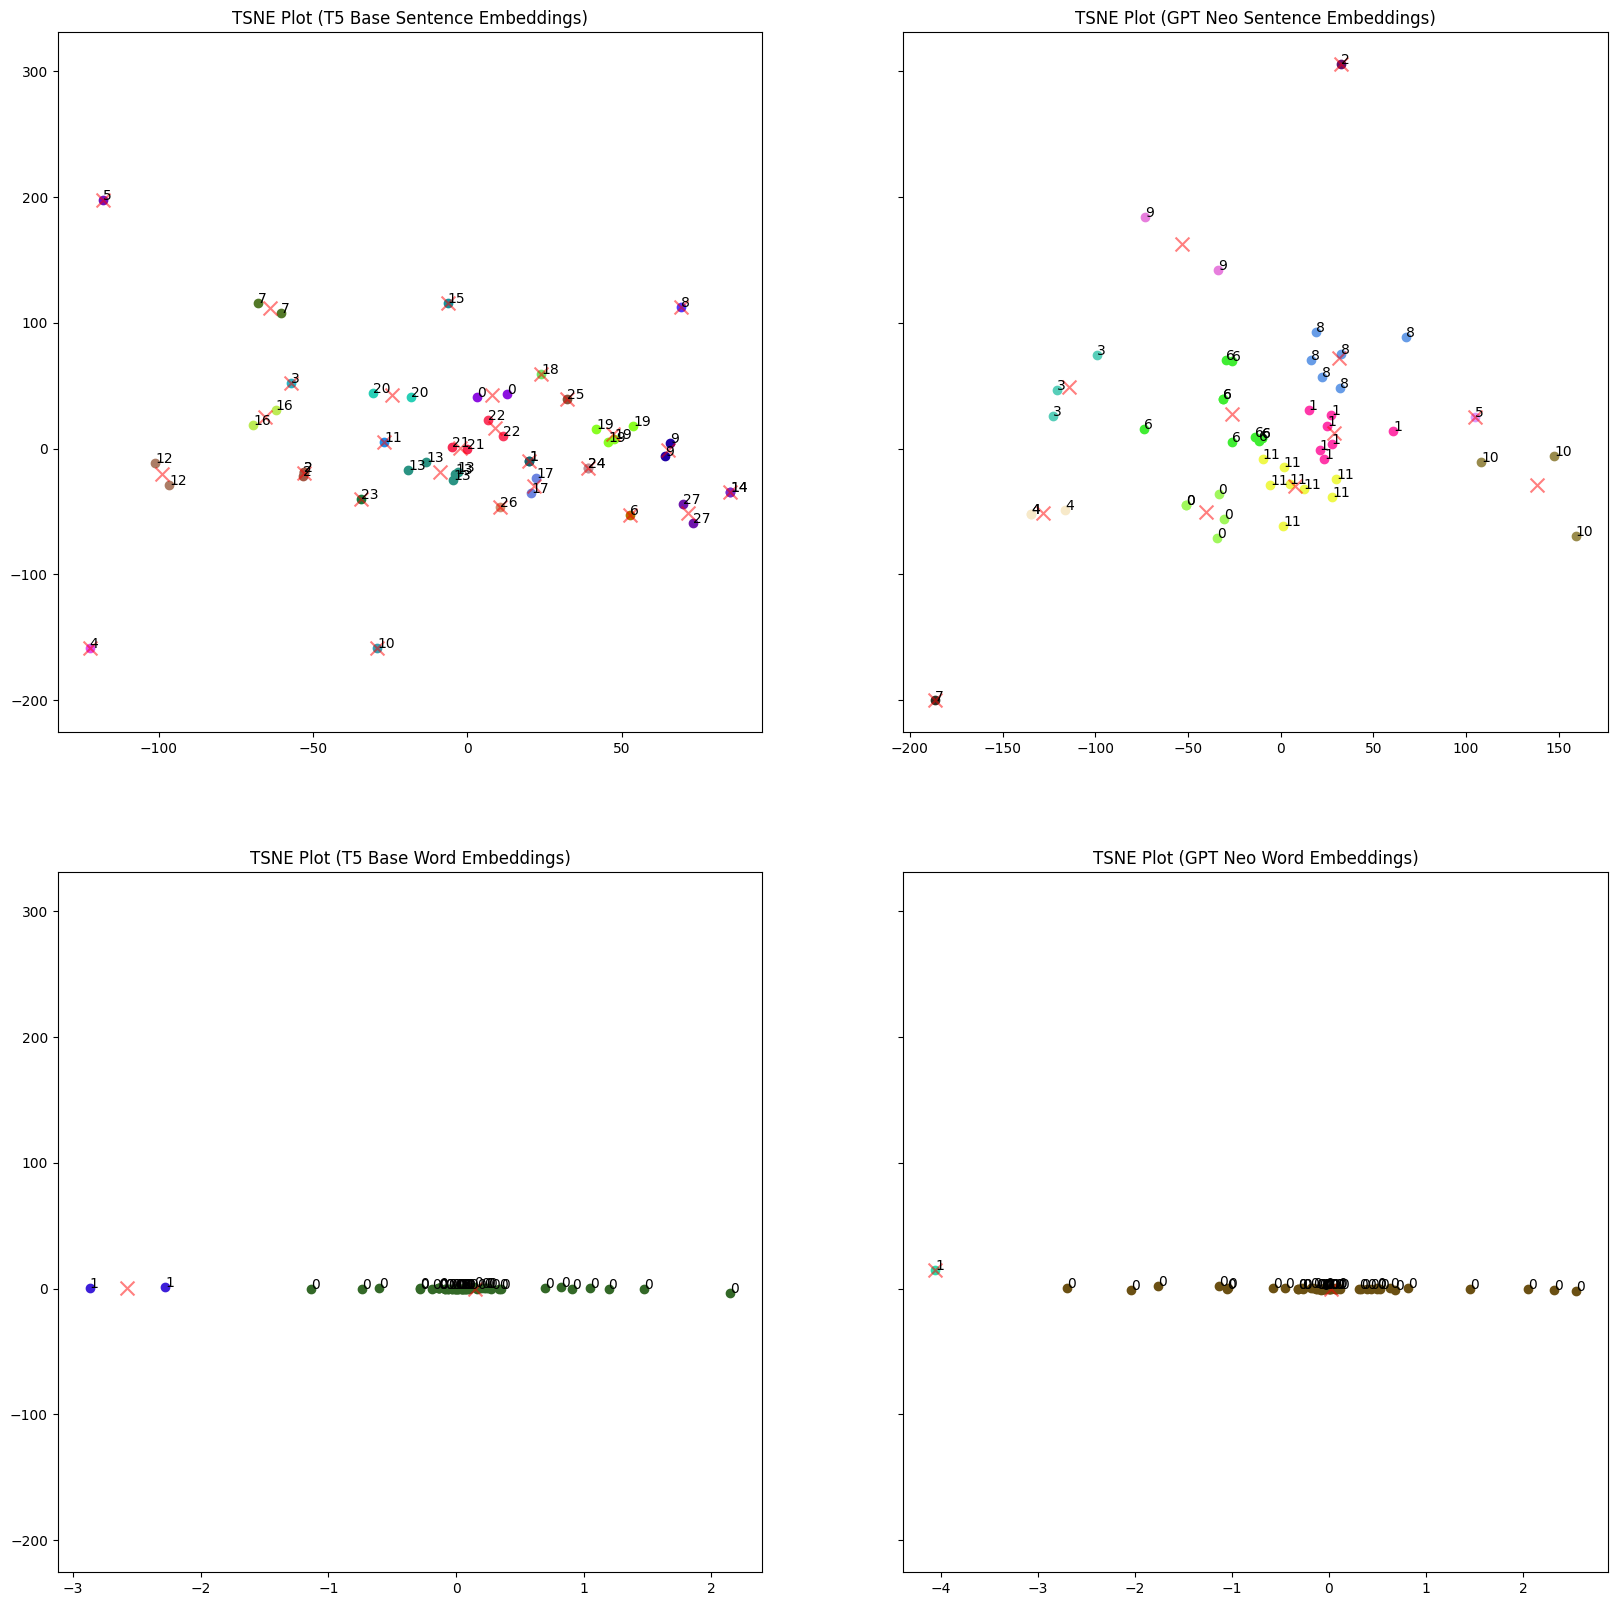

In [5]:
test = topic_classification.tsne_plot(clusters)

Zum Clustern von Word Embeddings scheint der Silhouette Score ein gutes Ergebnis zu erziehlen.
Für die Sentence Embeddings ist der Inertia-Wert trotz Anwendung des Silhouetten Scores gestiegen.

Den niedrigsten Inertia-Wert haben die Word Embeddings von T5 Base erzielt mit K = 2.

In [6]:
test

{'T5 Base Sentence Embeddings': 28,
 'GPT Neo Sentence Embeddings': 12,
 'T5 Base Word Embeddings': 2,
 'GPT Neo Word Embeddings': 2}

### Topic Klassifikation & Zuordnung <a class="anchor" id="9"></a>

#### Nearest Neighbors
Im Folgenden werden die K nearest Neighbors für jede "Embedding Art" bestimmt. Dabei werden dieselben Dokumente und Cluster wie bei der vorherigen Aufgabe verwendet, um eine gute Vergleichbarkeit herzustellen. Die nachfolgenden Plots bilden alle Clustermittelpunkte mit ihren jeweiligen nearest Neighbors aus den eigenen Clustern ab, die anderen Punkte werden der Übersicht halber nicht geplotet. Die nearest Neighbors sind mit Annotationen versehen, um sie den jeweiligen Clustermittelpunkten zuzuordnen. Es mag der Anschein erweckt werden, dass bei manchen Plots nicht "genügend" Nachbarn geplottet werden, dies liegt allerdings daran, das manche Cluster weniger als 10 Punkte haben, somit können sie auch innerhalb ihres clusters nicht mehr Nachbarn als Punkte haben.

C:\Users\Luki\Desktop\nlp-tasks\nlp-env-win-cuda\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (46) found smaller than n_clusters (47). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\Luki\Desktop\nlp-tasks\nlp-env-win-cuda\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (46) found smaller than n_clusters (48). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\Luki\Desktop\nlp-tasks\nlp-env-win-cuda\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (46) found smaller than n_clusters (49). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\Luki\Desktop\nlp-tasks\nlp-env-win-cuda\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (46) found smaller than n_clusters (47). Possibly due to duplicate p

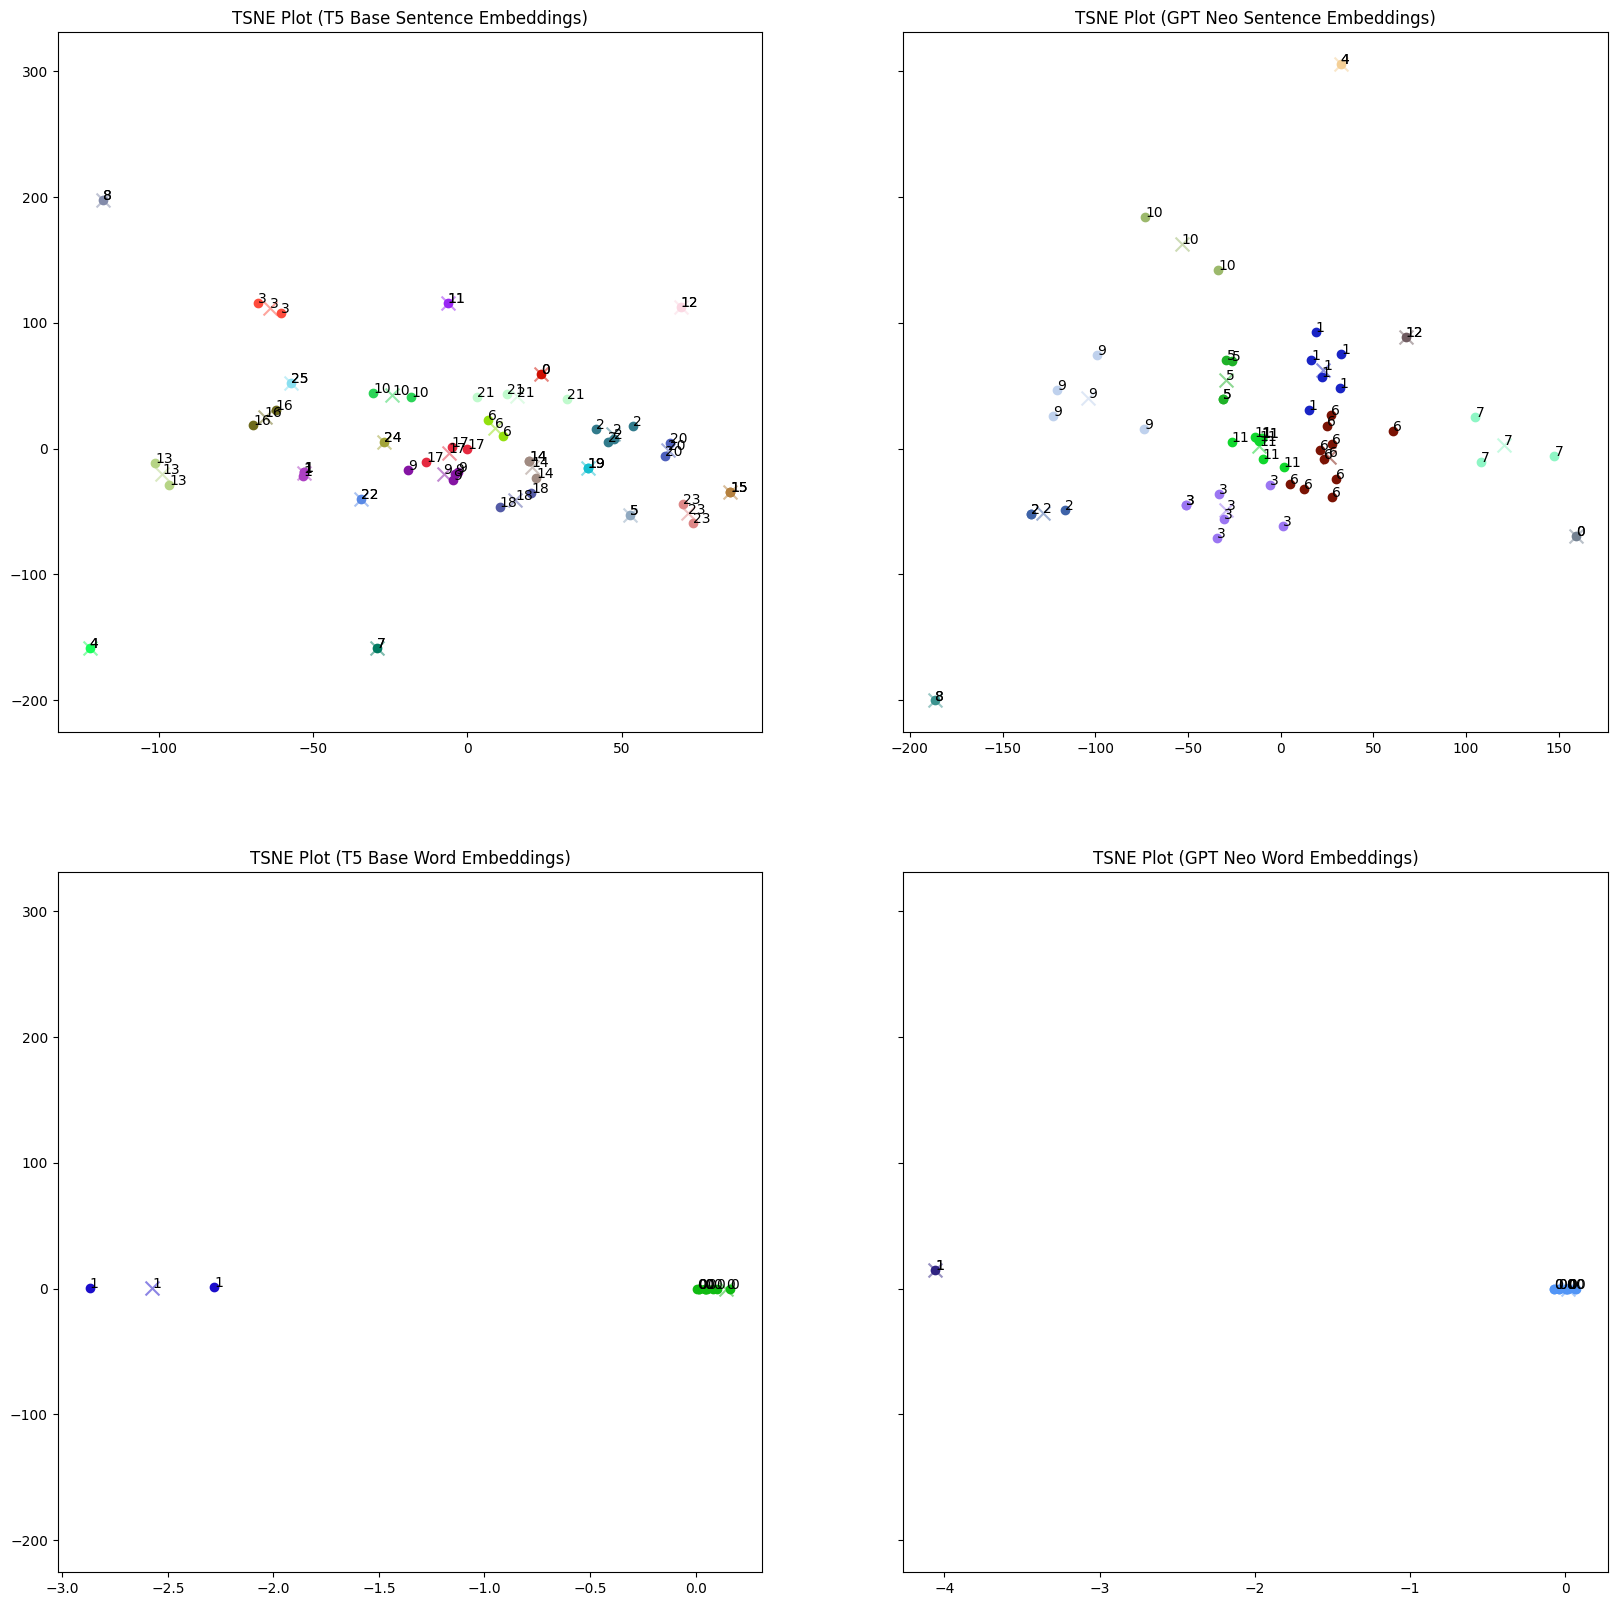

In [7]:
topic_classification.plot_n_neighbors(clusters, n_neighbors=10)

Das Clusterzentrum selbst reicht alleine nicht für die Beschreibung der kontextuellen Umgebung. Es bildet lediglich eine Art "Mittelwert" über seine zugehörigen Datenpunkte. Es ist also definitiv benachbarter Kontext erforderlich, um eine Themenbestimmung durchzuführen. Wie viel benötigt wird hängt davon ab, wie viele Dokumente pro Cluster existieren. Eine Themenzuweisung ist daher aufgrandlage der Embeddings nur bedingt möglich, da wie in den obigen Plots zu sehen ist, selbst für ein, durch den Silhouetten Score bestimmtes k, einige Cluster nahe beieinander liegen und eine falsch Klassifizieren daher sehr Wahrscheinlich ist (z.B. die Cluster 3, 6 und 11 im Plot der GPT Neo Sentence Embeddings). Für Cluster, die weiter auseinander liegen z.B. die Cluster 7 und 8 im Plot der T5 Sentence Embeddings, sollte eine Dokumentenklassifizierung aufgrund der Embeddings möglich sein.

## Referenzen
<a name="punkt_sent_tokenizer">[1]</a>: NLTK Project (2023). NLTK Documentation. https://www.nltk.org/api/nltk.tokenize.PunktSentenceTokenizer.html#nltk.tokenize.PunktSentenceTokenizer zuletzt eingesehen am: 23.01.2023.<br>
<a name="word_tokenizer">[2]</a>: NLTK Project (2023). NLTK Documentation. https://www.nltk.org/api/nltk.tokenize.TreebankWordTokenizer.html#nltk.tokenize.TreebankWordTokenizer zuletzt eingesehen am: 23.01.2023.